# 建立算法的管道模型
## 管道模型的概念和用法
### 管道模型的基本概念

In [1]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
X, y = make_blobs(n_samples=200, centers=2, cluster_std=5)
X_train, X_test, y_train, y_test=train_test_split(X,y,random_state=38)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled.shape, X_test_scaled.shape)

(150, 2) (50, 2)


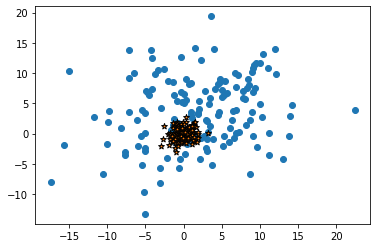

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(X_train[:,0],X_train[:,1])
plt.scatter(X_train_scaled[:,0],X_train_scaled[:,1], marker='*', edgecolors='k')
plt.show()

In [2]:
from sklearn.model_selection import GridSearchCV
params = {'hidden_layer_sizes':[(50,),(100,),(100,100)],
         'alpha':[0.0001, 0.001, 0.01, 0.1]}
grid = GridSearchCV(MLPClassifier(max_iter=1600,
                                  random_state=38), param_grid=params, cv=3)
grid.fit(X_train_scaled, y_train)
print('模型最佳得分：{:.2f}'.format(grid.best_score_))
print('模型最佳参数：{}'.format(grid.best_params_))

/Users/yy/miniforge3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1600) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yy/miniforge3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1600) reached and the optimization hasn't converged yet.
  warnings.warn(


模型最佳得分：0.65
模型最佳参数：{'alpha': 0.1, 'hidden_layer_sizes': (50,)}


In [3]:
print('测试集得分：{}'.format(grid.score(X_test_scaled, y_test)))

测试集得分：0.7


在交叉验证中，我们将以经用StandardScaler过的数据又拆分成了训练集和数据集，这样的得分是不准确的。然而网格搜索要做12次，又要用for循环遍历么？

In [4]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('scaler',StandardScaler()),
                     ('mlp',MLPClassifier(max_iter=1600,random_state=38))])
pipeline.fit(X_train, y_train)
print('使用管道模型的MLP模型评分：{:.2f}'.format(pipeline.score(X_test,y_test)))

使用管道模型的MLP模型评分：0.48


### 使用管道模型进行网格搜索

In [5]:
params = {'mlp__hidden_layer_sizes':[(50,),(100,),(100,100)],
         'mlp__alpha':[0.0001, 0.001, 0.01, 0.1]}
grid = GridSearchCV(pipeline, param_grid=params, cv=3)
grid.fit(X_train, y_train)
print('交叉验证最高分:{:.2f}'.format(grid.best_score_))
print('模型最优参数：{}'.format(grid.best_params_))
print('测试集得分：{}'.format(grid.score(X_test,y_test)))

交叉验证最高分:0.65
模型最优参数：{'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (100,)}
测试集得分：0.48


In [7]:
print(pipeline.steps)

[('scaler', StandardScaler()), ('mlp', MLPClassifier(max_iter=1600, random_state=38))]


## 使用管道模型对股票涨幅进行回归分析
### 数据集初始化

In [6]:
import pandas as pd
stocks = pd.read_csv('2019.csv', 
                     encoding = 'gbk')
X = stocks.loc[:,'现价':'流通股(亿)'].values
y = stocks['涨幅%']
print (X.shape, y.shape)

(3699, 22) (3699,)


In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
scores = cross_val_score(MLPRegressor(random_state=28),X,y,cv=3)
print ('模型平均分：{:.2f}'.format(scores.mean()))

模型平均分：-114792272.72


## 建立包含预处理和MLP模型的管道模型

In [11]:
from sklearn.pipeline import make_pipeline
pipeline = Pipeline([('scaler',StandardScaler()), 
                     ('mlp',MLPRegressor(random_state=18))])
# 使用make_pipeline无需指定每步名称，更加简洁
pipe = make_pipeline(StandardScaler(), MLPRegressor(random_state=18))
print(pipeline.steps)
print('\n',pipe.steps)

[('scaler', StandardScaler()), ('mlp', MLPRegressor(random_state=18))]

 [('standardscaler', StandardScaler()), ('mlpregressor', MLPRegressor(random_state=18))]


In [12]:
scores = cross_val_score(pipe,X,y,cv=3)
print('模型平均分：{:.2f}'.format(scores.mean()))

/Users/yy/miniforge3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


模型平均分：0.29


/Users/yy/miniforge3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### 向管道模型添加特征选择

In [13]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
pipe = make_pipeline(StandardScaler(),
                 SelectFromModel(RandomForestRegressor(random_state=18)),
                MLPRegressor(random_state=18))
pipe.steps

[('standardscaler', StandardScaler()),
 ('selectfrommodel',
  SelectFromModel(estimator=RandomForestRegressor(random_state=18))),
 ('mlpregressor', MLPRegressor(random_state=18))]

In [14]:
scores = cross_val_score(pipe, X,y, cv=3)
print('管道模型平均分：{:.2f}'.format(scores.mean()))

/Users/yy/miniforge3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yy/miniforge3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


管道模型平均分：0.60


/Users/yy/miniforge3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [15]:
pipe.fit(X,y)
mask = pipe.named_steps['selectfrommodel'].get_support()
print(mask)

[False  True False False False False  True False False False False False
  True False False False False False  True  True  True False]


/Users/yy/miniforge3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## 使用管道模型进行模型选择和参数调优
### 使用管道模型进行模型选择

In [16]:
params = [{'reg':[MLPRegressor(random_state=18)],
           'scaler':[StandardScaler(),None]},
         {'reg':[RandomForestRegressor(random_state=18)],
         'scaler':[None]}]
#下面对pipeline进行实例化
pipe = Pipeline([('scaler',StandardScaler()),('reg',MLPRegressor())])
grid = GridSearchCV(pipe, params, cv=3)
grid.fit(X,y)

print('最佳模型是：\n{}'.format(grid.best_params_))
print('\n模型最佳得分是:{:.2f}'.format(grid.best_score_))

/Users/yy/miniforge3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yy/miniforge3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


最佳模型是：
{'reg': RandomForestRegressor(random_state=18), 'scaler': None}

模型最佳得分是:0.66


### 使用管道模型寻找更优参数

In [17]:
params = [{'reg':[MLPRegressor(random_state=18)],
          'scaler':[StandardScaler(),None],
          'reg__hidden_layer_sizes':[(50,),(100,),(100,100)]},
         {'reg':[RandomForestRegressor(random_state=18)],
         'scaler':[None],
         'reg__n_estimators':[10,50,100]}]
pipe = Pipeline([('scaler',StandardScaler()),('reg',MLPRegressor())])
grid = GridSearchCV(pipe, params, cv=3)
grid.fit(X,y)

print('最佳模型是：\n{}'.format(grid.best_params_))
print('\n模型最佳得分是:{:.2f}'.format(grid.best_score_))

/Users/yy/miniforge3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yy/miniforge3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yy/miniforge3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yy/miniforge3/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/yy/miniforge3/lib/python3.9/site-packages

最佳模型是：
{'reg': RandomForestRegressor(n_estimators=10, random_state=18), 'reg__n_estimators': 10, 'scaler': None}

模型最佳得分是:0.68


In [18]:
params = [{'reg':[MLPRegressor(random_state=18, max_iter=1000)],
          'scaler':[StandardScaler(),None],
          'reg__hidden_layer_sizes':[(50,),(100,),(100,100)]},
         {'reg':[RandomForestRegressor(random_state=8)],
         'scaler':[None],
         'reg__n_estimators':[100,500,1000]}]
pipe = Pipeline([('scaler',StandardScaler()),('reg',MLPRegressor())])
grid = GridSearchCV(pipe, params, cv=3)
grid.fit(X,y)

print('最佳模型是：\n{}'.format(grid.best_params_))
print('\n模型最佳得分是:{:.2f}'.format(grid.best_score_))

最佳模型是：
{'reg': RandomForestRegressor(n_estimators=1000, random_state=8), 'reg__n_estimators': 1000, 'scaler': None}

模型最佳得分是:0.66
